In [ ]:
# Google Colab

# Instalação do Spark
!pip install pyspark

# Inicializa a seção
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

___
### **Pergunta 32 - Variação mensal na Receita levanto em conta os parcelamentos**
___

In [ ]:
# Leitura dos dados

df1 = spark.read.csv('/content/olist_order_payments_dataset.csv' , header=True, inferSchema=True)
df1.createOrReplaceTempView("order_payments")

df2 = spark.read.csv('/content/olist_orders_dataset.csv' , header=True, inferSchema=True)
df2.createOrReplaceTempView("orders")

df3 = spark.read.csv('/content/olist_products_dataset.csv' , header=True, inferSchema=True)
df3.createOrReplaceTempView("products")

df4 = spark.read.csv('/content/olist_order_items_dataset.csv' , header=True, inferSchema=True)
df4.createOrReplaceTempView("order_items")

In [ ]:
# Código para gerar sintaxe "Case When" para marcação das parcelas

# mes_max = 12
# ano_min = 2016
# ano_max = 2020

# lista_mes = [str(mes).zfill(2) for mes in range(1, mes_max+1)]

# lista_ano = list(range(2016,ano_max+1))
# lista_ano = [str(ano) for ano in range(ano_min, ano_max+1)]


# for i in lista_ano:
#     for j in lista_mes:
#         print(f"case when ultima_parcela >= {i}{j} and data_aprov < {i}{j} then valor_parcela else 0 end as parcela_{i}{j},")

In [ ]:
# Tabela com as parcelas agrupada por categoria

# Foi criada uma situação hipotética de cobrança de juros de acordo com o VALOR do produto

result = spark.sql('''

with tab2 as (
    with tab1 as (
        select
        op.order_id,                                                                                                              -- obs: tem order_id que não está na tabela (somente o da venda de 201609) order_payments.
        op.payment_sequential,                                                                                                    -- Por isso, vamos usar o ID dessa tabela pois, quaisquer outros id que não estejam nela, não tem como saber a quantidade de parcelas, etc.
        op.payment_type,
        op.payment_installments,
        op.payment_value,
        case                                                                                                                      -- aplica política de juros hipotética sobre o valor
          when payment_value <= 100 then 1.015* (payment_value / payment_installments)
          when payment_value > 100 and payment_value <= 500  then 1.025* (payment_value / payment_installments)
          when payment_value > 500 then 1.04* (payment_value / payment_installments)
        end as valor_parcela,
        case                                                                                                                      -- mostra o valor final, com juros
          when payment_value <= 100 then 1.015* payment_value
          when payment_value > 100 and payment_value <= 500  then 1.025* payment_value
          when payment_value > 500 then 1.04* payment_value
          end as valor_final,
        case                                                                                                                      -- mostra o valor da parcela
          when payment_value <= 100 then 0.015* payment_value
          when payment_value > 100 and payment_value <= 500  then 0.025* payment_value
          when payment_value > 500 then 0.04* payment_value
        end as valor_juros,
        coalesce(p.product_category_name, 'sem-info') as categoria                                                               -- a categoria nula pode entrar nototal, pois gerou caixa
        from order_payments op
        left join (select  order_id, product_id from order_items) oi on op.order_id = oi.order_id                                -- join com a tabela order_items
        left join products p on oi.product_id = p.product_id                                                                     -- join com a tabela de produtos
        where op.payment_installments > 0                                                                                        -- tem duas observações com número de parcelas iguais a zero
    )
    select
    payment_installments as qtd_parcelas,
    valor_parcela,
    case
      when o.order_approved_at is not null then date_format(o.order_approved_at , 'yyyyMM')
      else date_format(o.order_purchase_timestamp , 'yyyyMM')
    end as data_aprov,
    case                                                                                                                         -- Verifica se existe somente uma parcela. Se sim, é pagamento que cai no mesmo mês
      when payment_installments > 1 then date_format(add_months(to_date(data_aprov, 'yyyyMM'), payment_installments), 'yyyyMM')
      else data_aprov
    end AS ultima_parcela,
    datediff(to_date(ultima_parcela, 'yyyyMM'), to_date(date_format(o.order_approved_at , 'yyyyMM'), 'yyyyMM')) as dif_dias,     -- Trata o texto convertendo-o em data e calcula a diferença entre a data de aprvação e a da última parcela
    categoria
    from tab1
    left join orders o on tab1.order_id = o.order_id
    where o.order_status <> 'canceled'                                                                                           -- Alguns pedidos são cancelados
)
select
qtd_parcelas,
valor_parcela,
data_aprov,
ultima_parcela,
categoria,
case when ultima_parcela >= 201601 and data_aprov <= 201601 then valor_parcela else 0 end as parcela_201601,                     -- A data em questão tem que ser maior ou igual a data de aprovação E menor ou igual a data_final
case when ultima_parcela >= 201602 and data_aprov <= 201602 then valor_parcela else 0 end as parcela_201602,
case when ultima_parcela >= 201603 and data_aprov <= 201603 then valor_parcela else 0 end as parcela_201603,
case when ultima_parcela >= 201604 and data_aprov <= 201604 then valor_parcela else 0 end as parcela_201604,
case when ultima_parcela >= 201605 and data_aprov <= 201605 then valor_parcela else 0 end as parcela_201605,
case when ultima_parcela >= 201606 and data_aprov <= 201606 then valor_parcela else 0 end as parcela_201606,
case when ultima_parcela >= 201607 and data_aprov <= 201607 then valor_parcela else 0 end as parcela_201607,
case when ultima_parcela >= 201608 and data_aprov <= 201608 then valor_parcela else 0 end as parcela_201608,
case when ultima_parcela >= 201609 and data_aprov <= 201609 then valor_parcela else 0 end as parcela_201609,
case when ultima_parcela >= 201610 and data_aprov <= 201610 then valor_parcela else 0 end as parcela_201610,
case when ultima_parcela >= 201611 and data_aprov <= 201611 then valor_parcela else 0 end as parcela_201611,
case when ultima_parcela >= 201612 and data_aprov <= 201612 then valor_parcela else 0 end as parcela_201612,
case when ultima_parcela >= 201701 and data_aprov <= 201701 then valor_parcela else 0 end as parcela_201701,
case when ultima_parcela >= 201702 and data_aprov <= 201702 then valor_parcela else 0 end as parcela_201702,
case when ultima_parcela >= 201703 and data_aprov <= 201703 then valor_parcela else 0 end as parcela_201703,
case when ultima_parcela >= 201704 and data_aprov <= 201704 then valor_parcela else 0 end as parcela_201704,
case when ultima_parcela >= 201705 and data_aprov <= 201705 then valor_parcela else 0 end as parcela_201705,
case when ultima_parcela >= 201706 and data_aprov <= 201706 then valor_parcela else 0 end as parcela_201706,
case when ultima_parcela >= 201707 and data_aprov <= 201707 then valor_parcela else 0 end as parcela_201707,
case when ultima_parcela >= 201708 and data_aprov <= 201708 then valor_parcela else 0 end as parcela_201708,
case when ultima_parcela >= 201709 and data_aprov <= 201709 then valor_parcela else 0 end as parcela_201709,
case when ultima_parcela >= 201710 and data_aprov <= 201710 then valor_parcela else 0 end as parcela_201710,
case when ultima_parcela >= 201711 and data_aprov <= 201711 then valor_parcela else 0 end as parcela_201711,
case when ultima_parcela >= 201712 and data_aprov <= 201712 then valor_parcela else 0 end as parcela_201712,
case when ultima_parcela >= 201801 and data_aprov <= 201801 then valor_parcela else 0 end as parcela_201801,
case when ultima_parcela >= 201802 and data_aprov <= 201802 then valor_parcela else 0 end as parcela_201802,
case when ultima_parcela >= 201803 and data_aprov <= 201803 then valor_parcela else 0 end as parcela_201803,
case when ultima_parcela >= 201804 and data_aprov <= 201804 then valor_parcela else 0 end as parcela_201804,
case when ultima_parcela >= 201805 and data_aprov <= 201805 then valor_parcela else 0 end as parcela_201805,
case when ultima_parcela >= 201806 and data_aprov <= 201806 then valor_parcela else 0 end as parcela_201806,
case when ultima_parcela >= 201807 and data_aprov <= 201807 then valor_parcela else 0 end as parcela_201807,
case when ultima_parcela >= 201808 and data_aprov <= 201808 then valor_parcela else 0 end as parcela_201808,
case when ultima_parcela >= 201809 and data_aprov <= 201809 then valor_parcela else 0 end as parcela_201809,
case when ultima_parcela >= 201810 and data_aprov <= 201810 then valor_parcela else 0 end as parcela_201810,
case when ultima_parcela >= 201811 and data_aprov <= 201811 then valor_parcela else 0 end as parcela_201811,
case when ultima_parcela >= 201812 and data_aprov <= 201812 then valor_parcela else 0 end as parcela_201812,
case when ultima_parcela >= 201901 and data_aprov <= 201901 then valor_parcela else 0 end as parcela_201901,
case when ultima_parcela >= 201902 and data_aprov <= 201902 then valor_parcela else 0 end as parcela_201902,
case when ultima_parcela >= 201903 and data_aprov <= 201903 then valor_parcela else 0 end as parcela_201903,
case when ultima_parcela >= 201904 and data_aprov <= 201904 then valor_parcela else 0 end as parcela_201904,
case when ultima_parcela >= 201905 and data_aprov <= 201905 then valor_parcela else 0 end as parcela_201905,
case when ultima_parcela >= 201906 and data_aprov <= 201906 then valor_parcela else 0 end as parcela_201906,
case when ultima_parcela >= 201907 and data_aprov <= 201907 then valor_parcela else 0 end as parcela_201907,
case when ultima_parcela >= 201908 and data_aprov <= 201908 then valor_parcela else 0 end as parcela_201908,
case when ultima_parcela >= 201909 and data_aprov <= 201909 then valor_parcela else 0 end as parcela_201909,
case when ultima_parcela >= 201910 and data_aprov <= 201910 then valor_parcela else 0 end as parcela_201910,
case when ultima_parcela >= 201911 and data_aprov <= 201911 then valor_parcela else 0 end as parcela_201911,
case when ultima_parcela >= 201912 and data_aprov <= 201912 then valor_parcela else 0 end as parcela_201912,
case when ultima_parcela >= 202001 and data_aprov <= 202001 then valor_parcela else 0 end as parcela_202001,
case when ultima_parcela >= 202002 and data_aprov <= 202002 then valor_parcela else 0 end as parcela_202002,
case when ultima_parcela >= 202003 and data_aprov <= 202003 then valor_parcela else 0 end as parcela_202003,
case when ultima_parcela >= 202004 and data_aprov <= 202004 then valor_parcela else 0 end as parcela_202004,
case when ultima_parcela >= 202005 and data_aprov <= 202005 then valor_parcela else 0 end as parcela_202005,
case when ultima_parcela >= 202006 and data_aprov <= 202006 then valor_parcela else 0 end as parcela_202006,
case when ultima_parcela >= 202007 and data_aprov <= 202007 then valor_parcela else 0 end as parcela_202007,
case when ultima_parcela >= 202008 and data_aprov <= 202008 then valor_parcela else 0 end as parcela_202008,
case when ultima_parcela >= 202009 and data_aprov <= 202009 then valor_parcela else 0 end as parcela_202009,
case when ultima_parcela >= 202010 and data_aprov <= 202010 then valor_parcela else 0 end as parcela_202010,
case when ultima_parcela >= 202011 and data_aprov <= 202011 then valor_parcela else 0 end as parcela_202011,
case when ultima_parcela >= 202012 and data_aprov <= 202012 then valor_parcela else 0 end as parcela_202012
from tab2


''')

# Exibe
result.show(truncate=False)

+------------+------------------+----------+--------------+-----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------

In [ ]:
# Código para gerar sintaxe "Sum" para soma das parcelas

# for i in lista_ano:
#     for j in lista_mes:
#         print(f"sum(parcela_{i}{j}) as mes_{i}{j},")

In [ ]:
# Consulta agrupando por data

# Extrai um trecho do dataframe inicial (exclui colunas 0, 1, 2 e 3).
# Não captura as colunas qtd_parcela, svalor_parcela, data_aprov e ultima_parcela )
tab_agrup_categ = result.select(*result.columns[4:])

# Cria a view temporária
tab_agrup_categ.createOrReplaceTempView("tab_agrup_categ")


result_agrup_categ = spark.sql('''

select
categoria,
sum(parcela_201601) as mes_201601,
sum(parcela_201602) as mes_201602,
sum(parcela_201603) as mes_201603,
sum(parcela_201604) as mes_201604,
sum(parcela_201605) as mes_201605,
sum(parcela_201606) as mes_201606,
sum(parcela_201607) as mes_201607,
sum(parcela_201608) as mes_201608,
sum(parcela_201609) as mes_201609,
sum(parcela_201610) as mes_201610,
sum(parcela_201611) as mes_201611,
sum(parcela_201612) as mes_201612,
sum(parcela_201701) as mes_201701,
sum(parcela_201702) as mes_201702,
sum(parcela_201703) as mes_201703,
sum(parcela_201704) as mes_201704,
sum(parcela_201705) as mes_201705,
sum(parcela_201706) as mes_201706,
sum(parcela_201707) as mes_201707,
sum(parcela_201708) as mes_201708,
sum(parcela_201709) as mes_201709,
sum(parcela_201710) as mes_201710,
sum(parcela_201711) as mes_201711,
sum(parcela_201712) as mes_201712,
sum(parcela_201801) as mes_201801,
sum(parcela_201802) as mes_201802,
sum(parcela_201803) as mes_201803,
sum(parcela_201804) as mes_201804,
sum(parcela_201805) as mes_201805,
sum(parcela_201806) as mes_201806,
sum(parcela_201807) as mes_201807,
sum(parcela_201808) as mes_201808,
sum(parcela_201809) as mes_201809,
sum(parcela_201810) as mes_201810,
sum(parcela_201811) as mes_201811,
sum(parcela_201812) as mes_201812,
sum(parcela_201901) as mes_201901,
sum(parcela_201902) as mes_201902,
sum(parcela_201903) as mes_201903,
sum(parcela_201904) as mes_201904,
sum(parcela_201905) as mes_201905,
sum(parcela_201906) as mes_201906,
sum(parcela_201907) as mes_201907,
sum(parcela_201908) as mes_201908,
sum(parcela_201909) as mes_201909,
sum(parcela_201910) as mes_201910,
sum(parcela_201911) as mes_201911,
sum(parcela_201912) as mes_201912,
sum(parcela_202001) as mes_202001,
sum(parcela_202002) as mes_202002,
sum(parcela_202003) as mes_202003,
sum(parcela_202004) as mes_202004,
sum(parcela_202005) as mes_202005,
sum(parcela_202006) as mes_202006,
sum(parcela_202007) as mes_202007,
sum(parcela_202008) as mes_202008,
sum(parcela_202009) as mes_202009,
sum(parcela_202010) as mes_202010,
sum(parcela_202011) as mes_202011,
sum(parcela_202012) as mes_202012
from tab_agrup_categ
group by all


''')

# Exibe
result_agrup_categ.show(truncate=False)

+---------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------

In [ ]:
# Realiza uma espécia de "pivotamento", agrupando as datas em linhas e transformando as categorias em colunas

# Importa funções
from pyspark.sql.functions import explode, col, lit, regexp_replace
from pyspark.sql import functions as F

# Lista de colunas de mês
meses = [c for c in result_agrup_categ.columns if c != 'categoria']

# Usando a função explode para expandir as colunas de mês em linhas
df_exploded = result_agrup_categ.select('categoria', explode(F.array([F.struct(F.lit(c).alias('mês'), col(c).alias('valor')) for c in meses])).alias('exploded'))

# Pivotando os valores da coluna 'categoria' para se tornarem colunas
df_final = df_exploded.groupBy('exploded.mês').pivot('categoria').agg(F.first('exploded.valor'))

# Removendo 'mes_' dos valores da coluna 'mês' e ordenando
df_final = df_final.withColumn('mês', regexp_replace('mês', 'mes_', '').alias('mês')).orderBy('mês')

# Exibindo o DataFrame final
df_final.show()


+------+-------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------------+------------------+------------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+-------------------

In [ ]:

# colunas_a_somar = df_final.columns[1:]  # Todas as colunas exceto a primeira (mês)

# print('(')
# for i in colunas_a_somar:
#   print(f'{i} +')
# print(') as Total')

In [ ]:
# Consulta agrupando por data


# Cria a view temporária
df_final.createOrReplaceTempView("tab_final")


result_final = spark.sql('''

select * ,
(   agro_industria_e_comercio +
    alimentos +
    alimentos_bebidas +
    artes +
    artes_e_artesanato +
    artigos_de_festas +
    artigos_de_natal +
    audio +
    automotivo +
    bebes +
    bebidas +
    beleza_saude +
    brinquedos +
    cama_mesa_banho +
    casa_conforto +
    casa_conforto_2 +
    casa_construcao +
    cds_dvds_musicais +
    cine_foto +
    climatizacao +
    consoles_games +
    construcao_ferramentas_construcao +
    construcao_ferramentas_ferramentas +
    construcao_ferramentas_iluminacao +
    construcao_ferramentas_jardim +
    construcao_ferramentas_seguranca +
    cool_stuff +
    dvds_blu_ray +
    eletrodomesticos +
    eletrodomesticos_2 +
    eletronicos +
    eletroportateis +
    esporte_lazer +
    fashion_bolsas_e_acessorios +
    fashion_calcados +
    fashion_esporte +
    fashion_roupa_feminina +
    fashion_roupa_infanto_juvenil +
    fashion_roupa_masculina +
    fashion_underwear_e_moda_praia +
    ferramentas_jardim +
    flores +
    fraldas_higiene +
    industria_comercio_e_negocios +
    informatica_acessorios +
    instrumentos_musicais +
    la_cuisine +
    livros_importados +
    livros_interesse_geral +
    livros_tecnicos +
    malas_acessorios +
    market_place +
    moveis_colchao_e_estofado +
    moveis_cozinha_area_de_servico_jantar_e_jardim +
    moveis_decoracao +
    moveis_escritorio +
    moveis_quarto +
    moveis_sala +
    musica +
    papelaria +
    pc_gamer +
    pcs +
    perfumaria +
    pet_shop +
    portateis_casa_forno_e_cafe +
    portateis_cozinha_e_preparadores_de_alimentos +
    relogios_presentes +
    seguros_e_servicos +
    sinalizacao_e_seguranca +
    tablets_impressao_imagem +
    telefonia +
    telefonia_fixa +
    utilidades_domesticas ) as Total
from tab_final


''')

# Exibe
result_final.show()

+------+-------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------------------+------------------+------------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+-------------------

In [ ]:
# Convertendo a última view em Pandas
import pandas as pd
tab_final = result_final.toPandas()

# Salva a tabela compilada em formato 'csv'
tab_final.to_csv('/content/tab_compilada.csv', index=False)

In [ ]:
# Leitura do dataset
df=pd.read_csv('/content/tab_compilada.csv')

# Exibe
df.sample(5)

,mês,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,...,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sem-info,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas,Total
29,201806,6269.783297,2153.448341,1733.794262,3566.707292,0.000000,315.802039,1537.940573,6206.176980,64484.154546,...,132.3543,145654.174531,0.0,14937.711380,6897.814005,381.126608,34561.340741,4725.442223,94281.900580,1.542851e+06
27,201804,6917.470834,3396.937991,1330.577370,2535.275988,34.733300,345.601424,1563.930036,6514.175792,67666.721328,...,0.0000,112964.367756,0.0,25360.072212,2994.123679,501.356620,39059.917567,3998.351273,72319.500826,1.608494e+06
19,201708,1009.197550,898.873888,1113.049878,506.220286,21.314143,28.220383,143.723306,1437.955436,36531.051479,...,0.0000,39051.828113,0.0,15308.125685,487.297658,892.522079,14019.470373,5509.872858,39043.546761,7.613693e+05
43,201908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214.150233,...,0.0000,98.532484,0.0,10.561118,0.000000,0.000000,251.240419,0.000000,109.699552,3.341543e+03
38,201903,688.446496,216.317844,51.744575,33.820875,0.000000,0.000000,0.000000,133.793475,6891.851331,...,0.0000,9993.416762,0.0,272.020841,2131.157285,0.000000,2896.197325,71.492483,6675.429978,1.136017e+05


#### **Análise das receitas mensais**

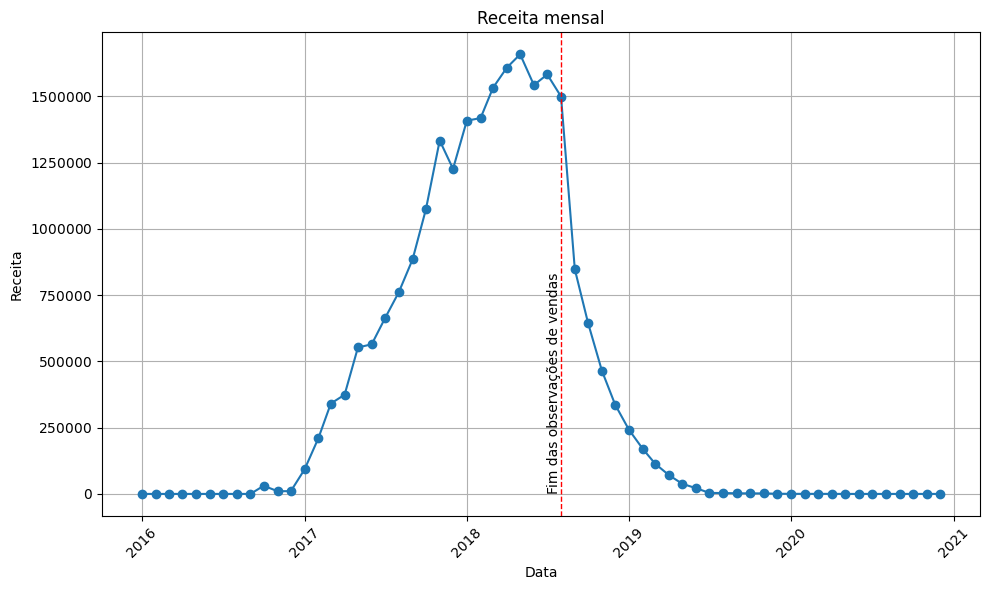

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

# Dados
meses = df['mês'].values
receita = df['Total'].values

# Converter números de mês para objetos de data
datas = [datetime.strptime(str(m), '%Y%m') for m in meses]

# Plotando o gráfico com rótulos de datas no eixo X
plt.figure(figsize=(10, 6))
plt.plot(datas, receita, marker='o', linestyle='-')
plt.title('Receita mensal')
plt.xlabel('Data')
plt.ylabel('Receita')

# Formatando os ticks do eixo Y para evitar a notação científica
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)
plt.grid(True)

# Adicionando linha vertical pontilhada em agosto de 2018
plt.axvline(x=datetime(2018, 8, 1), color='red', linestyle='--', linewidth=1)

# Adicionando texto vertical alinhado à esquerda da linha
plt.text(datetime(2018, 8, 1), min(receita)*1.05, 'Fim das observações de vendas', verticalalignment='bottom', horizontalalignment='right', rotation='vertical')

plt.tight_layout()
plt.show()



<br>

**Análise das receitas mensais**

A geração de caixa tem início em 2018-10 com um saldo de RS 30.766,95 e nos meses seguintes o saldo varia para RS 10.333.87 em 2016-11, RS10.353,78 em 2016-12 e, em 2017-01, há um salto para R$ 92.744,68, representando aumento de quase 9 vezes a receita anterior.

<br>

Á partir de 2017-01 a receita mensal é crescente até o mês 2017-11, atingindo o valor de RS 1.333.706,59. Em 2017-12 há redução na receita para RS 1.226.631,44, representando redução de 8,03% em relação ao mês anterior.

<br>

Em seguida, a taxa de crescimento volta a ser positiva e a receita aumenta até atingir o pico histórico de RS 1.658.961,80 em 2018-05, data à partir da qual a receita mensal decresce até 2018-08, onde atinge o valor de RS 1.499.712,25 e sendo este também o último mês do recorte de observação de vendas.

<br>

De 2018-08 em diante, não havendo observação de vendas, a receita decresce ao longo dos meses e em 2019-01 atinge o valor de RS 24.1786,98, em 2019-12 o valor de RS 611,08, até que, por fim, em 2020-06 a receita é de RS 12,25 e, no mês seguinte, já não há mais receita.

<br>


#### **Análise da distribuição da receita segmentada pelo tipo de venda (parcelada ou à vista)**

In [ ]:
# Montando uma view para análise das observações onde não há parcelas (venda à vista)


# Cria a view temporária
result.createOrReplaceTempView("parcelado")

# Consulta
df_avista = spark.sql('''

select * from parcelado
where qtd_parcelas = 1

''')

# Extrai um trecho do dataframe inicial (exclui colunas 0, 1, 2 e 3).
# Não captura as colunas qtd_parcela, svalor_parcela, data_aprov e ultima_parcela )
df_avista = df_avista.select(*result.columns[4:])


# Realiza uma espécia de "pivotamento", agrupando as datas em linhas e transformando as categorias em colunas

# Importa funções
from pyspark.sql.functions import explode, col, lit, regexp_replace
from pyspark.sql import functions as F

# Lista de colunas de mês
meses = [c for c in df_avista.columns if c != 'categoria']

# Usando a função explode para expandir as colunas de mês em linhas
df_exploded = df_avista.select('categoria', explode(F.array([F.struct(F.lit(c).alias('mês'), col(c).alias('valor')) for c in meses])).alias('exploded'))

# Pivotando os valores da coluna 'categoria' para se tornarem colunas
df_avista_final = df_exploded.groupBy('exploded.mês').pivot('categoria').agg(F.first('exploded.valor'))

# Removendo 'mes_' dos valores da coluna 'mês' e ordenando
df_avista_final = df_avista_final.withColumn('mês', regexp_replace('mês', 'mes_', '').alias('mês')).orderBy('mês')


# Consulta agrupando por data

# Cria a view temporária
df_avista_final.createOrReplaceTempView("tab_final")


# Consulta agrupando categorias
result_avista_final = spark.sql('''

select * ,
(   agro_industria_e_comercio +
    alimentos +
    alimentos_bebidas +
    artes +
    artes_e_artesanato +
    artigos_de_festas +
    artigos_de_natal +
    audio +
    automotivo +
    bebes +
    bebidas +
    beleza_saude +
    brinquedos +
    cama_mesa_banho +
    casa_conforto +
    casa_conforto_2 +
    casa_construcao +
    cds_dvds_musicais +
    cine_foto +
    climatizacao +
    consoles_games +
    construcao_ferramentas_construcao +
    construcao_ferramentas_ferramentas +
    construcao_ferramentas_iluminacao +
    construcao_ferramentas_jardim +
    construcao_ferramentas_seguranca +
    cool_stuff +
    dvds_blu_ray +
    eletrodomesticos +
    eletrodomesticos_2 +
    eletronicos +
    eletroportateis +
    esporte_lazer +
    fashion_bolsas_e_acessorios +
    fashion_calcados +
    fashion_esporte +
    fashion_roupa_feminina +
    fashion_roupa_infanto_juvenil +
    fashion_roupa_masculina +
    fashion_underwear_e_moda_praia +
    ferramentas_jardim +
    flores +
    fraldas_higiene +
    industria_comercio_e_negocios +
    informatica_acessorios +
    instrumentos_musicais +
    la_cuisine +
    livros_importados +
    livros_interesse_geral +
    livros_tecnicos +
    malas_acessorios +
    market_place +
    moveis_colchao_e_estofado +
    moveis_cozinha_area_de_servico_jantar_e_jardim +
    moveis_decoracao +
    moveis_escritorio +
    moveis_quarto +
    moveis_sala +
    musica +
    papelaria +
    pc_gamer +
    pcs +
    perfumaria +
    pet_shop +
    portateis_casa_forno_e_cafe +
    portateis_cozinha_e_preparadores_de_alimentos +
    relogios_presentes +
    seguros_e_servicos +
    sinalizacao_e_seguranca +
    tablets_impressao_imagem +
    telefonia +
    telefonia_fixa +
    utilidades_domesticas ) as Total
from tab_final


''')

# Exibe
result_avista_final.show(10,truncate=False)

+--------------+-------------------------+---------+-----------------+-----+------------------+-----------------+----------------+-----+----------+-----+-------+------------+----------+---------------+-------------+---------------+---------------+-----------------+---------+------------+--------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+----------+------------+----------------+------------------+-----------+---------------+-------------+---------------------------+----------------+---------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+---------------------+----------+-----------------+----------------------+---------------+----------------+------------+-------------------------+-------------------

In [ ]:
# Montando uma view para análise das observações onde há parcelas


# Cria a view temporária
result.createOrReplaceTempView("parcelado")

# Consulta
df_parcelado = spark.sql('''

select * from parcelado
where qtd_parcelas > 1

''')

# Extrai um trecho do dataframe inicial (exclui colunas 0, 1, 2 e 3).
# Não captura as colunas qtd_parcela, svalor_parcela, data_aprov e ultima_parcela )
df_parcelado = df_parcelado.select(*result.columns[4:])


# Realiza uma espécia de "pivotamento", agrupando as datas em linhas e transformando as categorias em colunas

# Importa funções
from pyspark.sql.functions import explode, col, lit, regexp_replace
from pyspark.sql import functions as F

# Lista de colunas de mês
meses = [c for c in df_parcelado.columns if c != 'categoria']

# Usando a função explode para expandir as colunas de mês em linhas
df_exploded = df_parcelado.select('categoria', explode(F.array([F.struct(F.lit(c).alias('mês'), col(c).alias('valor')) for c in meses])).alias('exploded'))

# Pivotando os valores da coluna 'categoria' para se tornarem colunas
df_parcelado_final = df_exploded.groupBy('exploded.mês').pivot('categoria').agg(F.first('exploded.valor'))

# Removendo 'mes_' dos valores da coluna 'mês' e ordenando
df_parcelado_final = df_parcelado_final.withColumn('mês', regexp_replace('mês', 'mes_', '').alias('mês')).orderBy('mês')


# Consulta agrupando por data

# Cria a view temporária
df_parcelado_final.createOrReplaceTempView("tab_final")

# COnsulta agrupando por categoria

result_parcelado_final = spark.sql('''

select * ,
(   agro_industria_e_comercio +
    alimentos +
    alimentos_bebidas +
    artes +
    artes_e_artesanato +
    artigos_de_festas +
    artigos_de_natal +
    audio +
    automotivo +
    bebes +
    bebidas +
    beleza_saude +
    brinquedos +
    cama_mesa_banho +
    casa_conforto +
    casa_conforto_2 +
    casa_construcao +
    cds_dvds_musicais +
    cine_foto +
    climatizacao +
    consoles_games +
    construcao_ferramentas_construcao +
    construcao_ferramentas_ferramentas +
    construcao_ferramentas_iluminacao +
    construcao_ferramentas_jardim +
    construcao_ferramentas_seguranca +
    cool_stuff +
    dvds_blu_ray +
    eletrodomesticos +
    eletrodomesticos_2 +
    eletronicos +
    eletroportateis +
    esporte_lazer +
    fashion_bolsas_e_acessorios +
    fashion_calcados +
    fashion_esporte +
    fashion_roupa_feminina +
    fashion_roupa_infanto_juvenil +
    fashion_roupa_masculina +
    fashion_underwear_e_moda_praia +
    ferramentas_jardim +
    flores +
    fraldas_higiene +
    industria_comercio_e_negocios +
    informatica_acessorios +
    instrumentos_musicais +
    la_cuisine +
    livros_importados +
    livros_interesse_geral +
    livros_tecnicos +
    malas_acessorios +
    market_place +
    moveis_colchao_e_estofado +
    moveis_cozinha_area_de_servico_jantar_e_jardim +
    moveis_decoracao +
    moveis_escritorio +
    moveis_quarto +
    moveis_sala +
    musica +
    papelaria +
    pc_gamer +
    pcs +
    perfumaria +
    pet_shop +
    portateis_casa_forno_e_cafe +
    portateis_cozinha_e_preparadores_de_alimentos +
    relogios_presentes +
    sinalizacao_e_seguranca +
    tablets_impressao_imagem +
    telefonia +
    telefonia_fixa +
    utilidades_domesticas ) as Total
from tab_final


''')

# Exibe
result_parcelado_final.show(10,truncate=False)

# Observação: categoria "seguras_e_servicos" não foi incluída na soma, pois entrou na tabela quando o filtro "where qtd_parcelas > 1"
# sendo assim, no pivotamento, ela não aparece como coluna

+--------------+-------------------------+---------+-----------------+-----+------------------+-----------------+----------------+-----+----------+-----+-------+------------+----------+---------------+-------------+---------------+---------------+-----------------+---------+------------+--------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+----------+------------+----------------+------------------+-----------+---------------+-------------+---------------------------+----------------+---------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+---------------------+----------+-----------------+----------------------+---------------+----------------+------------+-------------------------+-------------------

In [ ]:
# Salvando a view em Pandas
df_avista = result_avista_final.toPandas()
df_parcelado = result_parcelado_final.toPandas()

# Salva a tabela compilada em formato 'csv'
df_avista.to_csv('/content/df_avista.csv', index=False)
df_parcelado.to_csv('/content/df_parcelado.csv', index=False)

# Leitura do dataset
df_avista = pd.read_csv('/content/df_avista.csv')
df_parcelado = pd.read_csv('/content/df_parcelado.csv')

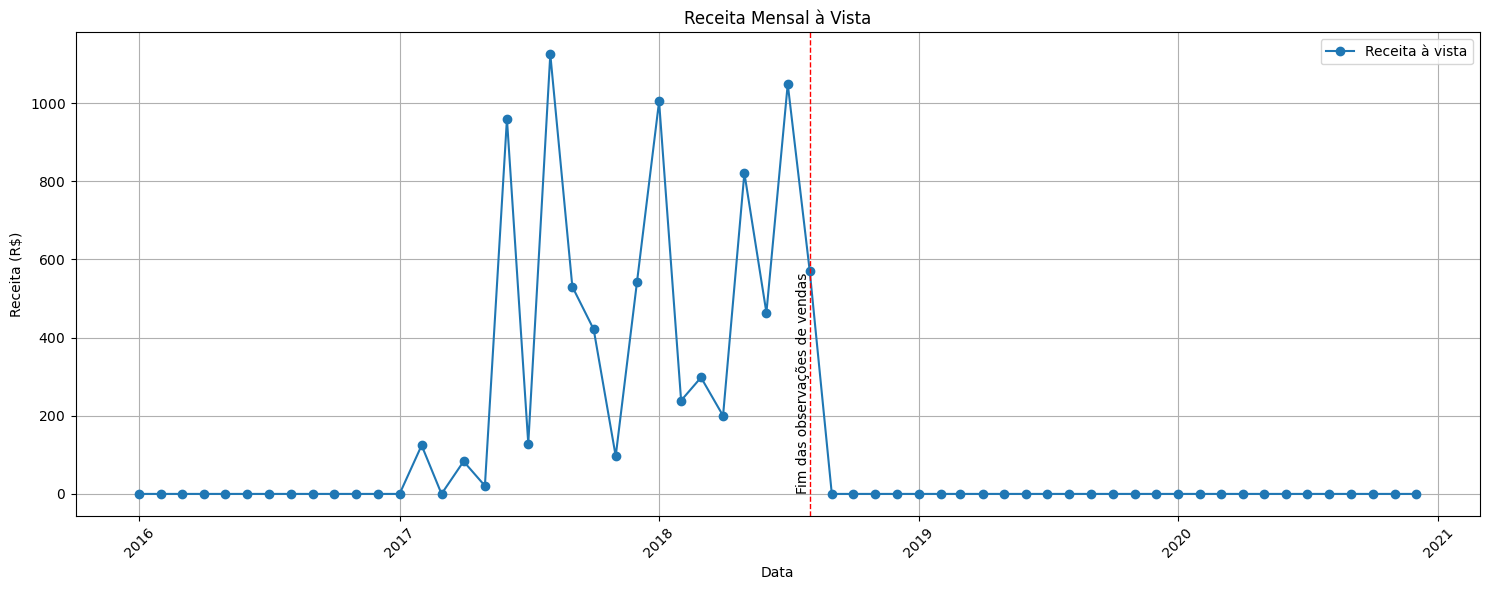

In [ ]:
# Gráfico mensal da receita a vista

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

# Dados
meses = df_avista['mês'].values
receita_avista = df_avista['Total'].values

# Extrair ano e mês de cada valor de 'mês'
anos_meses = np.array([mes.split('_')[1] for mes in meses])

# Converter os valores de ano e mês em objetos de data
datas = [datetime.strptime(ano_mes, '%Y%m') for ano_mes in anos_meses]

# Plotando o gráfico apenas para a receita à vista
plt.figure(figsize=(15, 6))
plt.plot(datas, receita_avista, marker='o', linestyle='-', label='Receita à vista')
plt.title('Receita Mensal à Vista')
plt.xlabel('Data')
plt.ylabel('Receita (R$)')
plt.legend()

# Formatando os ticks do eixo Y para evitar a notação científica
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)
plt.grid(True)

# Adicionando linha vertical pontilhada em agosto de 2018
plt.axvline(x=datetime(2018, 8, 1), color='red', linestyle='--', linewidth=1)

# Adicionando texto vertical alinhado à esquerda da linha
plt.text(datetime(2018, 8, 1), min(receita_avista) * 1.05, 'Fim das observações de vendas', verticalalignment='bottom', horizontalalignment='right', rotation='vertical')

plt.tight_layout()
plt.show()


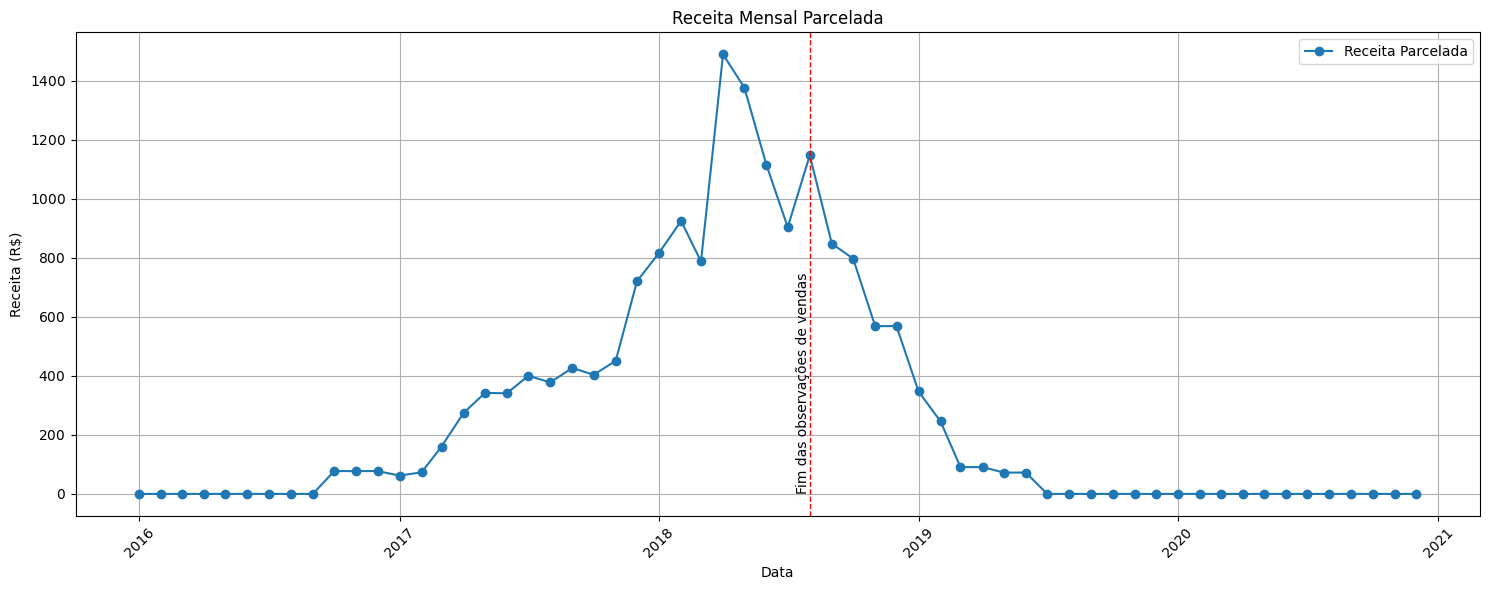

In [ ]:
# Gráfico mensal da receita parcelada

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime

# Dados
meses = df_parcelado['mês'].values
receita_parcelado = df_parcelado['Total'].values

# Extrair ano e mês de cada valor de 'mês'
anos_meses = np.array([mes.split('_')[1] for mes in meses])

# Converter os valores de ano e mês em objetos de data
datas = [datetime.strptime(ano_mes, '%Y%m') for ano_mes in anos_meses]

# Plotando o gráfico apenas para a receita parcelada
plt.figure(figsize=(15, 6))
plt.plot(datas, receita_parcelado, marker='o', linestyle='-', label='Receita Parcelada')
plt.title('Receita Mensal Parcelada')
plt.xlabel('Data')
plt.ylabel('Receita (R$)')
plt.legend()

# Formatando os ticks do eixo Y para evitar a notação científica
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45)
plt.grid(True)

# Adicionando linha vertical pontilhada em agosto de 2018
plt.axvline(x=datetime(2018, 8, 1), color='red', linestyle='--', linewidth=1)

# Adicionando texto vertical alinhado à esquerda da linha
plt.text(datetime(2018, 8, 1), min(receita_parcelado) * 1.05, 'Fim das observações de vendas', verticalalignment='bottom', horizontalalignment='right', rotation='vertical')

plt.tight_layout()
plt.show()


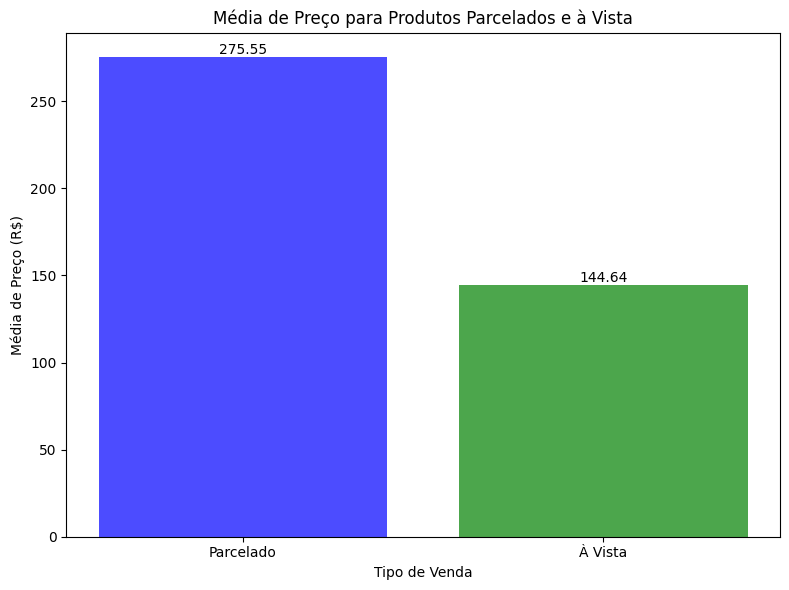

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'resumo_parcelas' seja o nome do seu dataframe
# Calculando a média de preço para cada categoria

med_avista = df_avista['Total'].mean()
med_par = df_parcelado['Total'].mean()

# Criando um DataFrame com as médias de preço
df_medias_preco = pd.DataFrame({'Tipo de Venda': ['Parcelado', 'À Vista'],
                                'Média de Preço': [med_par, med_avista]})

# Plotando o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(df_medias_preco['Tipo de Venda'], df_medias_preco['Média de Preço'], color=['blue', 'green'], alpha=0.7)

# Adicionando rótulos e título
plt.title('Média de Preço para Produtos Parcelados e à Vista')
plt.xlabel('Tipo de Venda')
plt.ylabel('Média de Preço (R$)')

# Adicionando os valores nas barras
for i, valor in enumerate(df_medias_preco['Média de Preço']):
    plt.text(i, valor, '{:.2f}'.format(valor), ha='center', va='bottom')

# Mostrando o gráfico
plt.tight_layout()
plt.show()



<br>

**Análise da distribuição da receita segmentada pelo tipo de venda (parcelada ou à vista)**

A variação nas vendas parceladas e nas vendas à vista pode fornecer inormações sobre o comportamento do consumidor e as condições econômicas.

<br>

Um aumento consistente nas vendas parceladas ao longo do tempo pode indicar uma tendência positiva de consumo e uma maior confiança do consumidor na economia. Isso pode sugerir uma demanda crescente por produtos ou serviços de alto valor, onde os consumidores preferem parcelar o pagamento ao longo do tempo. Ressalta-se que o valor médio dos itens parcelados é de RS 275,55, 1,9vezes maior que o valor médio dos itens vendidos à vista, que é de RS 144,64.

<br>

As vendas parceladas oferecem um fluxo de caixa mais estável ao longo do tempo, uma vez que os pagamentos são distribuídos em várias parcelas. Isso pode ser especialmente útil para empresas que buscam manter uma previsão financeira mais equilibrada e estável. Além disso, ao permitir o parcelamento, as empresas têm a oportunidade de aumentar o ticket médio das vendas, já que os clientes podem adquirir produtos ou serviços de maior valor sem a necessidade de pagar tudo de uma só vez.

<br>

Essa modalidade de pagamento também pode ser uma estratégia eficaz para atrair novos clientes. Ao oferecer opções de parcelamento, as empresas podem conquistar consumidores que, de outra forma, não teriam condições de adquirir os produtos ou serviços oferecidos. Isso pode resultar em uma expansão da base de clientes e, consequentemente, em um aumento nas vendas.

<br>

Além disso, as vendas parceladas podem contribuir para a fidelização dos clientes. Aqueles que optam por parcelar seus pagamentos podem desenvolver uma relação de longo prazo com a empresa, aumentando a probabilidade de realizarem compras futuras e, possivelmente, recomendarem a empresa para outras pessoas.

<br>

Por outro lado, a variação observada nas compras à vista pode indicar uma sensibilidade ao preço por parte dos consumidores, onde eles estão procurando por descontos ou promoções especiais antes de fazer uma compra. Se as vendas à vista estiverem diminuindo, isso pode sugerir que os consumidores estão enfrentando restrições financeiras ou incertezas econômicas, levando-os a adiar compras ou buscar opções de pagamento mais flexíveis.

<br>

Variações nas vendas à vista podem refletir mudanças no comportamento de gastos dos consumidores, especialmente em relação a itens não essenciais. Uma diminuição nas vendas à vista pode indicar uma redução nos gastos discricionários. Além disso, alterações nas políticas de preços, como descontos especiais para pagamento à vista, podem influenciar diretamente a variação nas vendas à vista.

<br>

Contudo, as vendas à vista oferecem alguns benefícios. Receber o pagamento à vista proporciona liquidez imediata, o que pode ser crucial para cobrir despesas operacionais, pagar fornecedores ou aproveitar oportunidades de investimento. Além disso, essa modalidade de pagamento reduz o risco de inadimplência, uma vez que não há dependência da capacidade do cliente de pagar parcelas futuras.

<br>


#### **Análise da correlação entre quantidade de parcelas e valor total do produto**

In [ ]:
# Montando uma view para análise das parcelas

# View temporária
result.createOrReplaceTempView("result")

# Consulta
resumo_parcelas = spark.sql('''

select
qtd_parcelas,
data_aprov,
ultima_parcela,
valor_parcela
from result
order by valor_parcela desc

''')

# Exibição
resumo_parcelas.show()

# sum(valor_parcela) as valor_parcela from result
# group by qtd_parcelas, data_aprov, ultima_parcela,

+------------+----------+--------------+------------------+
|qtd_parcelas|data_aprov|ultima_parcela|     valor_parcela|
+------------+----------+--------------+------------------+
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201710|        201710|        14210.6432|
|           1|    201807|        201807|         7565.8752|
|           1|    201807|        201807|         7565.8752|
|           1|    201807|        201807|         7565.8752|
|           1|    201807|        201807|         7565.8752|
|           1|    201807|        201807|         7199.0984|
|           1|    201705|        201705|

In [ ]:
resumo_parcelas = spark.sql('''

select
payment_installments as qtd_parcelas,
payment_value as valor_total
from order_payments

''')

# Exibição
resumo_parcelas.show()

+------------+-----------+
|qtd_parcelas|valor_total|
+------------+-----------+
|           8|      99.33|
|           1|      24.39|
|           1|      65.71|
|           8|     107.78|
|           2|     128.45|
|           2|      96.12|
|           1|      81.16|
|           3|      51.84|
|           6|     341.09|
|           1|      51.95|
|           8|     188.73|
|           1|      141.9|
|           1|      75.78|
|           5|     102.66|
|           4|     105.28|
|          10|     157.45|
|           1|     132.04|
|           1|      98.94|
|           4|     244.15|
|           3|     136.71|
+------------+-----------+
only showing top 20 rows



In [ ]:
# Salvando a view em Pandas
df_resumo_parcelas = resumo_parcelas.toPandas()

# Salva a tabela compilada em formato 'csv'
df_resumo_parcelas.to_csv('/content/df_resumo_parcelas.csv', index=False)

# Leitura do dataset
df_resumo_parcelas=pd.read_csv('/content/df_resumo_parcelas.csv')

In [ ]:
# Quadro de correlação

df_resumo_parcelas.corr()

,qtd_parcelas,valor_total
qtd_parcelas,1.00,0.33
valor_total,0.33,1.00


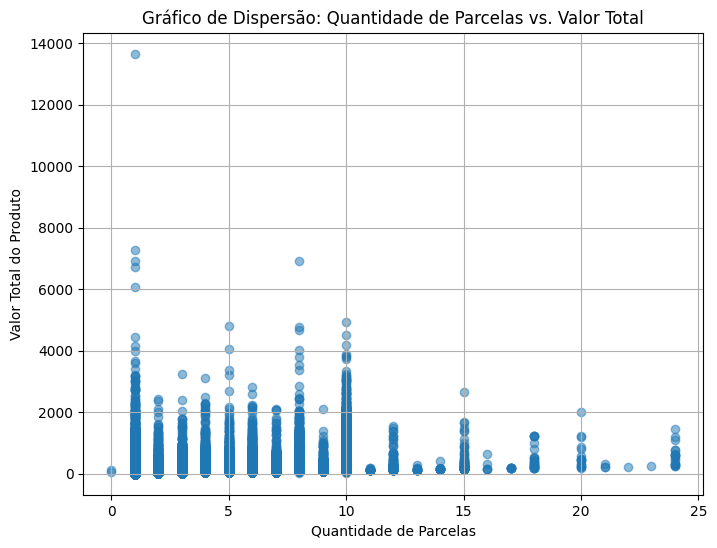

In [ ]:
import matplotlib.pyplot as plt

# Plotando o gráfico de dispersão
plt.figure(figsize=(8, 6))
plt.scatter(df_resumo_parcelas['qtd_parcelas'], df_resumo_parcelas['valor_total'], alpha=0.5)
plt.title('Gráfico de Dispersão: Quantidade de Parcelas vs. Valor Total')
plt.xlabel('Quantidade de Parcelas')
plt.ylabel('Valor Total do Produto')
plt.grid(True)
plt.show()



<br>

**Análise da correlação entre quantidade de parcelas e valor total do produto**

Uma correlação de 0,33 entre a quantidade de parcelas e o valor do produto sugere uma correlação positiva moderada entre essas duas variáveis. Isso significa que à medida que a quantidade de parcelas aumenta, o valor total do produto tende a aumentar também, e vice-versa, mas essa relação não é extremamente forte. Em outras palavras, embora haja uma tendência para os valores se moverem juntos, a relação não é tão forte a ponto de garantir que um aumento em uma variável sempre resultará em um aumento proporcional na outra variável.

<br>

Essa correlação sugere que outros fatores podem estar influenciando o valor do produto além da quantidade de parcelas, e vice-versa. Portanto, ao tomar decisões relacionadas a estratégias de precificação e modalidades de pagamento, é importante considerar não apenas a quantidade de parcelas oferecidas, mas também outros elementos que podem impactar o valor total do produto.

___

### **Pergunta 33 - Clientes que mais utilizam diferentes forma de pagamento**
___

In [7]:
# Leitura dos dados

df1 = spark.read.csv('/content/olist_customers_dataset.csv' , header=True, inferSchema=True)
df1.createOrReplaceTempView("customers")

df2 = spark.read.csv('/content/olist_orders_dataset.csv' , header=True, inferSchema=True)
df2.createOrReplaceTempView("orders")

df3 = spark.read.csv('/content/olist_order_payments_dataset.csv' , header=True, inferSchema=True)
df3.createOrReplaceTempView("order_payments")

In [10]:
# Consulta

spark.sql('''

  select
	c.customer_id ,
	count(distinct op.payment_type) as qtd_formas,
	count( op.payment_type) as qtd_entradas
from
	customers c
	left join orders o on c.customer_id = o.customer_id
	left join order_payments op on o.order_id = op.order_id
group by
	c.customer_id
order by qtd_entradas desc

''').show(truncate=False)

+--------------------------------+----------+------------+
|customer_id                     |qtd_formas|qtd_entradas|
+--------------------------------+----------+------------+
|9af2372a1e49340278e7c1ef8d749f34|1         |29          |
|92cd3ec6e2d643d4ebd0e3d6238f69e2|2         |26          |
|b246eeed30b362c09d867b9e598bee51|2         |22          |
|270c23a11d024a44c896d1894b261a83|1         |21          |
|eed931d3a5222a9a511d18be7fd2a5ba|2         |19          |
|13aa59158da63ba0e93ec6ac2c07aacb|2         |19          |
|de832e8dbb1f588a47013e53feaa67cc|2         |15          |
|1eebfdb7083031b40f727fb71f6cd5b2|1         |15          |
|d1ea705f2fdd8f98eff86c2691652e60|2         |14          |
|7bb57d182bdc11653fac1593436df8bf|1         |14          |
|c7e04083bffe04edab6d27fb982dc6cc|2         |13          |
|5152585f73b24d675bd2e8316b4fa99d|1         |13          |
|351e40989da90e70487765f6ea15d54b|1         |13          |
|c98632bdc4c3bd2066cdea237cf8f468|2         |12         

___

### **Pergunta 34 - Vendedor com maior número de parcelamentos em seus pedidos**
___

In [40]:
# Leitura dos dados

df1 = spark.read.csv('/content/olist_customers_dataset.csv' , header=True, inferSchema=True)
df1.createOrReplaceTempView("customers")

df2 = spark.read.csv('/content/olist_order_items_dataset.csv' , header=True, inferSchema=True)
df2.createOrReplaceTempView("order_items")

df3 = spark.read.csv('/content/olist_order_payments_dataset.csv' , header=True, inferSchema=True)
df3.createOrReplaceTempView("payments")

df4 = spark.read.csv('/content/olist_order_reviews_dataset.csv' , header=True, inferSchema=True)
df4.createOrReplaceTempView("reviews")

df5 = spark.read.csv('/content/olist_orders_dataset.csv' , header=True, inferSchema=True)
df5.createOrReplaceTempView("orders")

df5 = spark.read.csv('/content/olist_products_dataset.csv' , header=True, inferSchema=True)
df5.createOrReplaceTempView("products")

df7 = spark.read.csv('/content/olist_sellers_dataset.csv' , header=True, inferSchema=True)
df7.createOrReplaceTempView("sellers")

<!-- Consulta -->

In [52]:
spark.sql('''

select
oi.order_id,
oi.seller_id,
max(p.payment_sequential) as qtd_entradas
from order_items oi
left join payments p on oi.order_id = p.order_id
group by oi.order_id, oi.seller_id
order by qtd_entradas desc

''').show(truncate=False)

+--------------------------------+--------------------------------+------------+
|order_id                        |seller_id                       |qtd_entradas|
+--------------------------------+--------------------------------+------------+
|fa65dad1b0e818e3ccc5cb0e39231352|06532f10282704ef4c69168b914b77be|29          |
|ccf804e764ed5650cd8759557269dc13|1900267e848ceeba8fa32d80c1a5f5a8|26          |
|285c2e15bebd4ac83635ccc563dc71f4|dbd66278cbfe1aa1000f90a217ca4695|22          |
|895ab968e7bb0d5659d16cd74cd1650c|3d0cd21d41671c46f82cd11176bf7277|21          |
|895ab968e7bb0d5659d16cd74cd1650c|822166ed1e47908f7cfb49946d03c726|21          |
|fedcd9f7ccdc8cba3a18defedd1a5547|7c67e1448b00f6e969d365cea6b010ab|19          |
|ee9ca989fc93ba09a6eddc250ce01742|4a3ca9315b744ce9f8e9374361493884|19          |
|4bfcba9e084f46c8e3cb49b0fa6e6159|7b0df942f46435babab05d49b744b2c4|15          |
|21577126c19bf11a0b91592e5844ba78|6481e96574816ead57975da2c0f6d80d|15          |
|3c58bffb70dcf45f12bdf66a3c2